In [3]:
import pandas as pd
df = pd.read_csv('../data/cleaned_austin_v1.csv')
old_data = pd.read_csv('../data/listings_detailed.csv')

geo_cols = old_data[['id', 'latitude', 'longitude']].copy()
geo_cols['id'] = geo_cols['id'].astype(str)

df['id'] = df['id'].astype(str)
df = df.merge(geo_cols, on='id', how='left')

df

,id,host_is_superhost,host_response_rate,host_acceptance_rate,host_total_listings_count,host_has_profile_pic,accommodates,minimum_nights,maximum_nights,instant_bookable,...,neighbourhood_cleansed_78751,neighbourhood_cleansed_78752,neighbourhood_cleansed_78753,neighbourhood_cleansed_78754,neighbourhood_cleansed_78756,neighbourhood_cleansed_78757,neighbourhood_cleansed_78758,neighbourhood_cleansed_78759,latitude,longitude
0,5456,1.0,1.00,0.95,4.0,1.0,3,2,90,0,...,False,False,False,False,False,False,False,False,30.260570,-97.734410
1,5769,1.0,1.00,0.95,4.0,1.0,2,1,14,0,...,False,False,False,False,False,False,False,False,30.456970,-97.784220
2,6413,1.0,1.00,1.00,1.0,1.0,2,30,90,0,...,False,False,False,False,False,False,False,False,30.248850,-97.735870
3,6448,1.0,1.00,1.00,2.0,1.0,2,3,365,1,...,False,False,False,False,False,False,False,False,30.260340,-97.764870
4,8502,0.0,0.60,0.70,1.0,1.0,2,4,90,0,...,False,False,False,False,False,False,False,False,30.234660,-97.736820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,847159076072987428,0.0,0.95,1.00,88.0,1.0,10,2,365,1,...,False,False,False,False,False,False,False,False,30.289220,-97.747269
14364,847171709264672413,0.0,0.95,1.00,88.0,1.0,2,2,365,1,...,False,False,False,False,False,False,False,False,30.290238,-97.748501
14365,847178203609366885,0.0,0.95,1.00,88.0,1.0,5,2,365,1,...,False,False,False,False,False,False,False,False,30.287227,-97.726643
14366,847256590826352221,0.0,1.00,1.00,2.0,1.0,6,2,60,0,...,False,False,False,False,False,False,False,False,30.381710,-97.952860


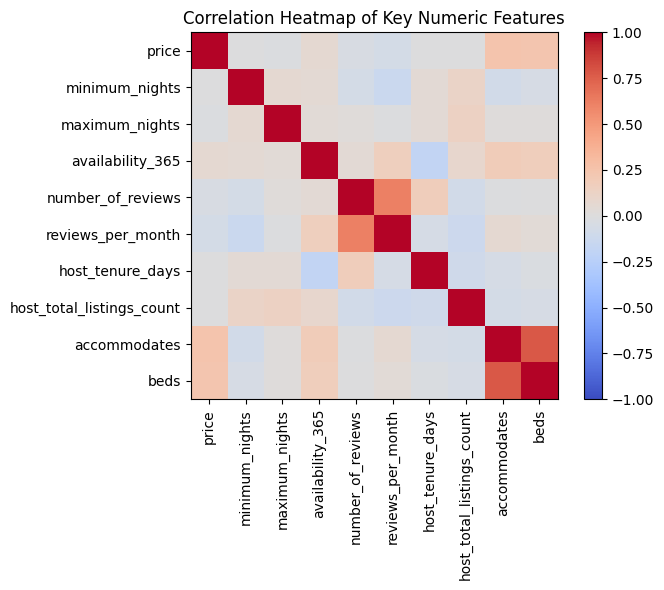

In [4]:
import matplotlib.pyplot as plt
numeric_cols = [
    'price',
    'minimum_nights',
    'maximum_nights',
    'availability_365',
    'number_of_reviews',
    'reviews_per_month',
    'host_tenure_days',
    'host_total_listings_count',
    'accommodates',
    'beds',
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation Heatmap of Key Numeric Features')
plt.tight_layout()
plt.show()

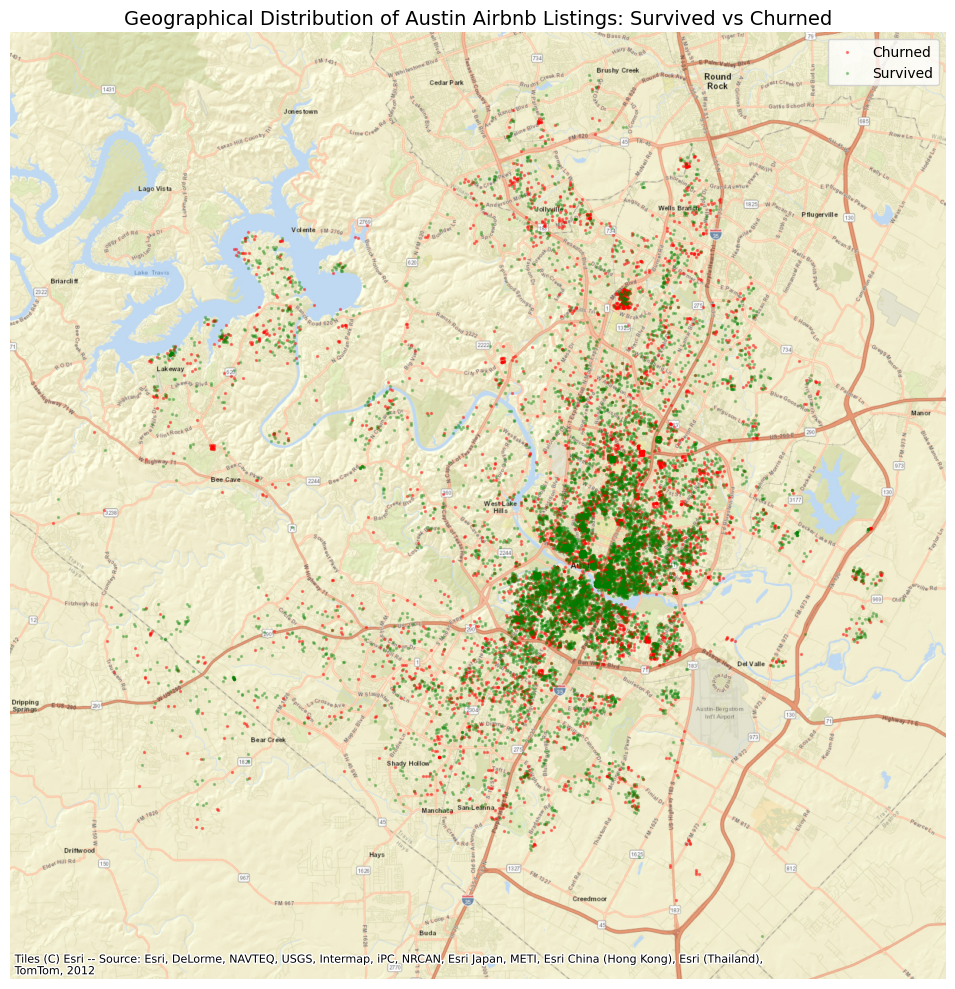

In [42]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

df = df.dropna(subset=['latitude', 'longitude'])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326",
)

gdf = gdf.to_crs(epsg=3857)

survivors = gdf[gdf['survived'] == 1]
churners = gdf[gdf['survived'] == 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Make churners red
churners.plot(
    ax=ax,
    markersize=2,
    alpha=0.4,
    color='red',
    label='Churned'
)

# Make survivors green
survivors.plot(
    ax=ax,
    markersize=2,
    alpha=0.3,
    color='green',
    label='Survived'
)


# Add Austin basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldStreetMap,
    zoom=12
)



ax.set_axis_off()
plt.title('Geographical Distribution of Austin Airbnb Listings: Survived vs Churned', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/tf2/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/opt/anaconda3/envs/tf2/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/opt/anaconda3/envs/tf2/lib/python3.10/site-packages/sklearn/inspection/

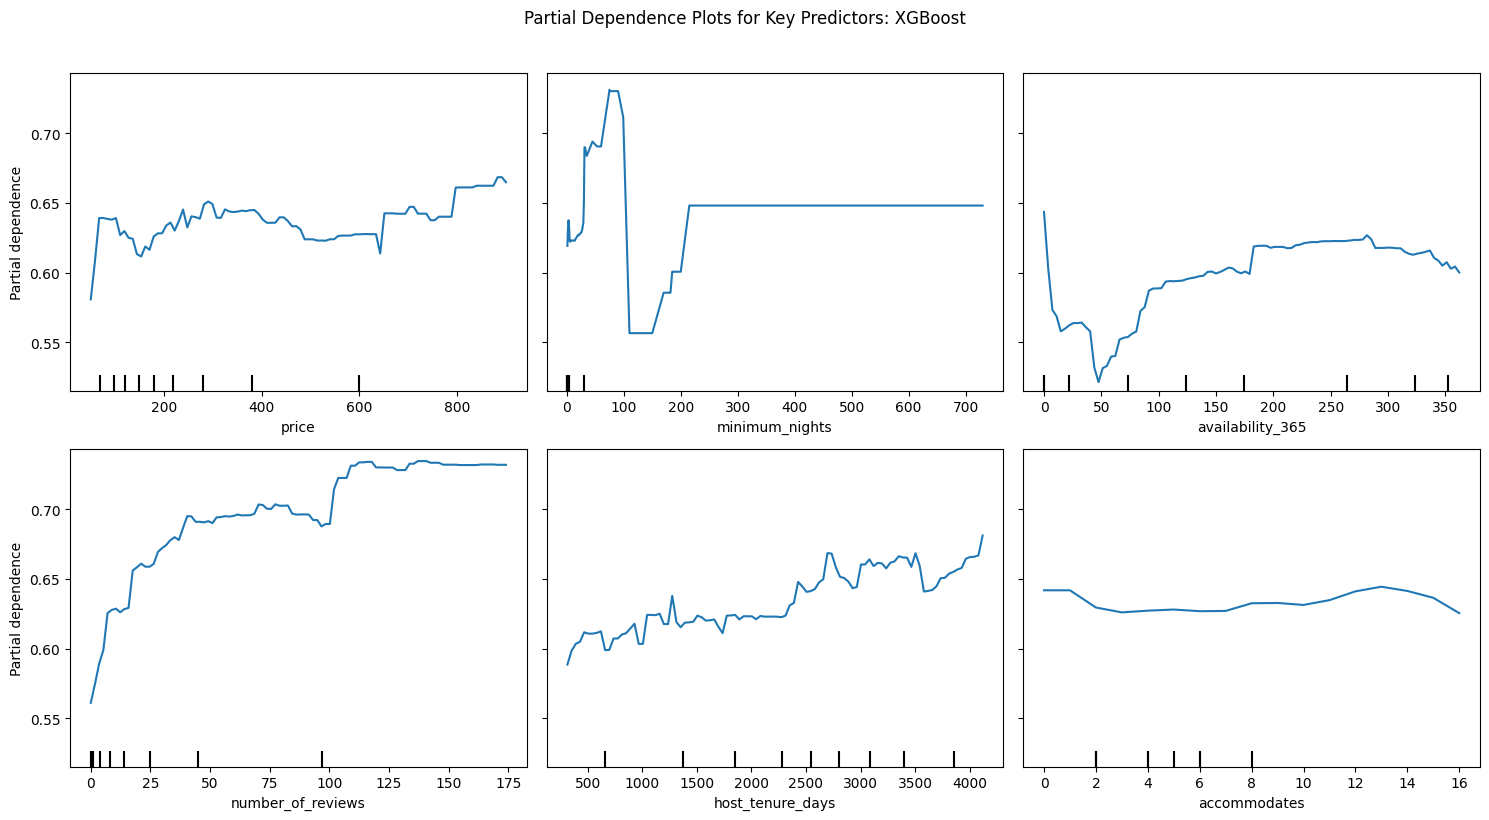

In [50]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
df = pd.read_csv('../data/cleaned_austin_v1.csv')

y = df['survived']
X = df.drop(columns=['id', 'survived'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# df['minimum_nights'] = df['minimum_nights'].clip(1, 90)
# df['maximum_nights'] = df['maximum_nights'].clip(1, 365)

# Train XGBoost model
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
)
xgb.fit(X_train, y_train)

from sklearn.inspection import PartialDependenceDisplay
features_for_pdp = [
    'price',
    'minimum_nights',
    'availability_365',
    'number_of_reviews',
    'host_tenure_days',
    'accommodates',
]

fig, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(15, 8)
)

PartialDependenceDisplay.from_estimator(
    xgb,
    X_train,
    features_for_pdp,
    ax=ax,
    kind='average',
)

plt.suptitle("Partial Dependence Plots for Key Predictors: XGBoost", y=1.02)
plt.tight_layout()
plt.show()


In [53]:
import shap

/opt/anaconda3/envs/tf2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PermutationExplainer explainer: 11495it [03:46, 48.80it/s]                           
/var/folders/ch/gvv9gx511f5c1_hhjzbt1ncm0000gp/T/ipykernel_39069/4135406235.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


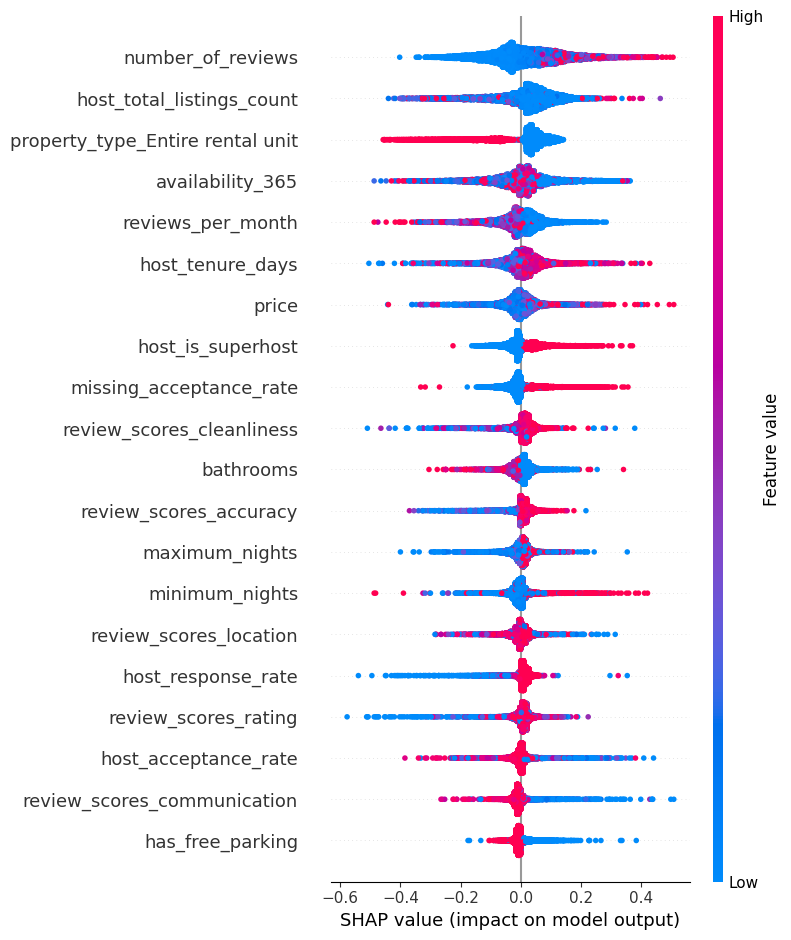

In [60]:
import shap
shap.initjs()
X_train_shap = X_train.astype('float32')

explainer = shap.Explainer(xgb.predict, X_train_shap)
shap_values = explainer(X_train_shap)

shap.summary_plot(
    shap_values,
    X_train,
    show=True,
)
